In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelBinarizer

# Out of Bound data testing

This workbook is designed to test how the existing model responds when presented with out of bound data. That is data that was not part of the training material.  It tests weather it is possible to use the confidence levels to establish if the model can be used to identify when it has not previously seen the date before. 

In [2]:
model = tf.keras.models.load_model('models/convlstm_model_Datetime_2022_05_26__23_52_24__loss_0.08553284406661987_acc_0.9906666874885559.h5')

FEATURES_PATH = "data/my_20_sec_features-additional_sites-2022_07_24__17_28_44.npy"
LABELS_PATH = "data/my_20_sec_labels-additional_sites-2022_07_24__17_28_44.npy"
SCALER_MAX = 709.0

SEED = 42

2022-07-25 10:33:52.638405: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)

with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)

In [4]:
features_scaled = features/SCALER_MAX
features_scaled.max()

1.8025387870239775

In [5]:
labels_order = [
    "www.amazon.co.uk",
    "www.bbc.co.uk",
    "www.ebay.co.uk",
    "www.facebook.com",
    "www.google.co.uk",
    "www.google.com",
    "www.twitter.com",
    "www.uwe.ac.uk",
    "www.wikipedia.com",
    "www.youtube.com"
]

In [6]:
labels_in_band = []
labels_out_of_band = []
features_in_band = []
features_out_of_band = []


for i in range(len(labels)):
    if labels[i] in labels_order:
        labels_in_band.append(labels[i])
        features_in_band.append(features_scaled[i])
    else:
        labels_out_of_band.append(labels[i])
        features_out_of_band.append(features_scaled[i])

labels_in_band = np.array(labels_in_band)
labels_out_of_band = np.array(labels_out_of_band)
features_in_band = np.array(features_in_band)
features_out_of_band=np.array(features_out_of_band)

print(f"labels_in_band - {labels_in_band.shape}")
print(f"labels_out_of_band - {labels_out_of_band.shape}")
print(f"features_in_band - {features_in_band.shape}")
print(f"features_out_of_band - {features_out_of_band.shape}")


labels_in_band - (2206,)
labels_out_of_band - (1054,)
features_in_band - (2206, 200, 150, 2)
features_out_of_band - (1054, 200, 150, 2)


In [7]:
label_binariser = LabelBinarizer()
label_binariser.fit(labels_order)
labels_encoded = label_binariser.transform(labels_in_band)
# labels_encoded = label_binariser.fit_transform(labels)
labels_encoded.shape

(2206, 10)

In [8]:
model_evaluation_history = model.evaluate(features_in_band, labels_encoded)


69/69 [==============================] - 25s 347ms/step - loss: 0.6628 - accuracy: 0.8495


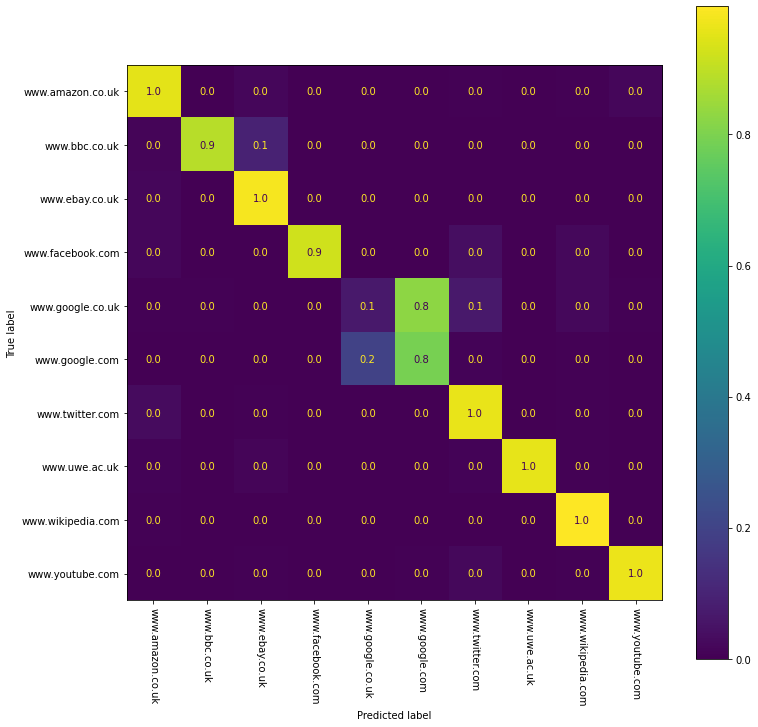

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       220
           1       0.99      0.89      0.94       207
           2       0.89      0.98      0.93       240
           3       1.00      0.92      0.96       233
           4       0.25      0.07      0.11       219
           5       0.51      0.79      0.62       236
           6       0.87      0.96      0.91       220
           7       1.00      0.96      0.98       202
           8       0.94      1.00      0.97       229
           9       0.97      0.96      0.97       200

    accuracy                           0.85      2206
   macro avg       0.83      0.85      0.83      2206
weighted avg       0.83      0.85      0.83      2206



In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
y_true = np.argmax(labels_encoded, axis=1)
unique_y = np.unique(y_true)
predictions =  np.argmax(model.predict(features_in_band), axis=1)
cm = confusion_matrix(y_true, predictions, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
    )
disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
plt.show()
print(classification_report(y_true, predictions))

In [10]:
in_band_scores = model.predict(features_in_band)
out_of_band_scores = model.predict(features_out_of_band)

(array([[1.944e+03, 1.200e+01, 9.000e+00, 6.000e+00, 4.000e+00, 3.000e+00,
         2.000e+00, 6.000e+00, 6.000e+00, 2.140e+02],
        [2.021e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 1.000e+00, 1.000e+00, 1.830e+02],
        [1.927e+03, 6.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
         6.000e+00, 5.000e+00, 1.000e+01, 2.410e+02],
        [1.974e+03, 5.000e+00, 6.000e+00, 3.000e+00, 5.000e+00, 2.000e+00,
         2.000e+00, 3.000e+00, 2.000e+00, 2.040e+02],
        [1.973e+03, 6.700e+01, 4.800e+01, 2.900e+01, 2.900e+01, 2.800e+01,
         1.600e+01, 1.300e+01, 2.000e+00, 1.000e+00],
        [1.756e+03, 7.000e+00, 1.800e+01, 2.100e+01, 3.600e+01, 3.200e+01,
         3.100e+01, 5.600e+01, 7.200e+01, 1.770e+02],
        [1.933e+03, 1.100e+01, 1.000e+01, 5.000e+00, 7.000e+00, 1.200e+01,
         8.000e+00, 7.000e+00, 6.000e+00, 2.070e+02],
        [2.012e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 1.

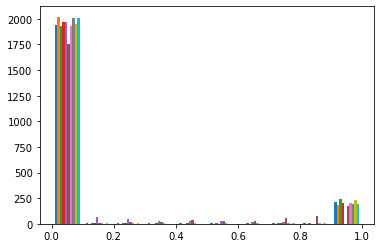

In [11]:
plt.hist(in_band_scores)

(array([[9.110e+02, 1.700e+01, 1.100e+01, 8.000e+00, 4.000e+00, 6.000e+00,
         5.000e+00, 4.000e+00, 1.300e+01, 7.500e+01],
        [1.046e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00],
        [6.670e+02, 2.900e+01, 1.000e+01, 9.000e+00, 1.500e+01, 1.100e+01,
         1.700e+01, 1.900e+01, 3.000e+01, 2.470e+02],
        [1.007e+03, 6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
         0.000e+00, 3.000e+00, 6.000e+00, 2.600e+01],
        [1.049e+03, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [1.041e+03, 4.000e+00, 4.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [8.470e+02, 1.500e+01, 1.300e+01, 1.400e+01, 9.000e+00, 1.100e+01,
         1.300e+01, 1.000e+01, 2.700e+01, 9.500e+01],
        [9.780e+02, 9.000e+00, 2.000e+00, 3.000e+00, 6.000e+00, 0.000e+00,
         1.000e+00, 1.

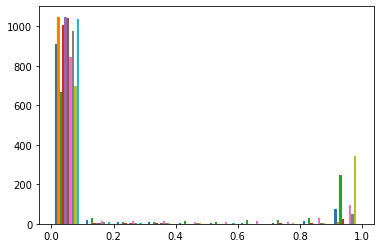

In [14]:
plt.hist(out_of_band_scores)

In [15]:
len(out_of_band_scores)

1054

In [67]:
def get_band_score_delta_from_cut_off(cut_off, v=False):

    count_out_of_band = 0
    for score in out_of_band_scores:
        if score.max() > cut_off:
            count_out_of_band += 1
    out_of_band_above_cut_off = count_out_of_band/len(out_of_band_scores)

    if v:
        print(f"Out of band above cut-off - {out_of_band_above_cut_off}")

    count_in_band = 0
    for score in in_band_scores:
        if score.max() > cut_off:
            count_in_band += 1
    in_band_above_cut_off = count_in_band/len(in_band_scores)
    if v:
        print(f"In band above cut-off - {in_band_above_cut_off}")
    return in_band_above_cut_off - out_of_band_above_cut_off, in_band_above_cut_off

In [68]:
get_band_score_delta_from_cut_off(0.99, v=True)

Out of band above cut-off - 0.6062618595825426
In band above cut-off - 0.7030825022665458


(0.09682064268400314, 0.7030825022665458)

In [73]:
deltas = [get_band_score_delta_from_cut_off(i/100)[0] for i in range(50,100, 1)]
band_accuracy = [get_band_score_delta_from_cut_off(i/100)[1] for i in range(50,100, 1)]

Text(0.5, 0.98, 'Model confidence against threshold')

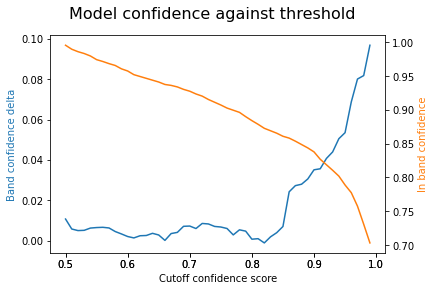

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, label="1")
ax2 = fig.add_subplot(111, label="2", frame_on=False)

ax.plot(np.arange(0.5, 1, 0.01), deltas, color="C0")
ax.set_ylabel("Band confidence delta", color="C0")
ax.set_xlabel("Cutoff confidence score", color="black")
ax2.plot(np.arange(0.5, 1, 0.01), band_accuracy, color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel("In band confidence", color="C1")
ax2.yaxis.set_label_position('right')

fig.suptitle('Model confidence against threshold', fontsize=16)
